In [ ]:
import os
from PIL import Image  # 이미지 형식 변환에 필요 (pip install pillow)
import pandas as pd  # CSV 읽기를 위해 필요 (pip install pandas)
from bing_image_downloader import downloader  # pip install bing-image-downloader

# CSV 파일 경로
csv_file_path = 'C:/GitHub/Stupid_Moon/deu_university/Digital Image Fundamentals/Teamproject/people_list.csv'  # 환경에 맞게 경로 수정

# 디렉토리 설정
base_directory_path = 'C:/GitHub/Stupid_Moon/deu_university/Digital Image Fundamentals/Teamproject/data_set'

# CSV에서 카테고리 읽기
df = pd.read_csv(csv_file_path)

# 열 이름 확인 및 출력
print("CSV 파일의 열 이름:", df.columns)

# 'Name'이라는 열이 존재하는지 확인
if 'Name' in df.columns:
    categories = df['Name'].tolist()  # 'Name' 열에 각 인물 이름이 있다고 가정
else:
    raise KeyError("CSV 파일에 'Name'이라는 열이 존재하지 않습니다. 올바른 열 이름을 확인해주세요.")

# 각 카테고리별 데이터를 다운로드 및 저장
for query in categories:
    query_path = os.path.join(base_directory_path, query)
    downloader.download(query, limit=100, output_dir=base_directory_path, adult_filter_off=True, force_replace=False, timeout=60)

    # 단일 폴더에 저장
    final_path = os.path.join(base_directory_path, query)
    os.makedirs(final_path, exist_ok=True)

    # 이미지 정리 및 변환 함수
    def convert_and_delete_originals(query_path, final_path):
        if os.path.exists(query_path):
            file_names = os.listdir(query_path)
            for file_name in file_names:
                src_path = os.path.join(query_path, file_name)
                dest_file_name = os.path.splitext(file_name)[0] + ".jpeg"  # .jpeg 확장자로 변경
                dest_path = os.path.join(final_path, dest_file_name)

                # 이미지 변환 및 기존 파일 삭제
                try:
                    with Image.open(src_path) as img:
                        rgb_img = img.convert("RGB")  # RGB로 변환 (JPEG는 RGB만 지원)
                        rgb_img.save(dest_path, "JPEG")  # JPEG 형식으로 저장
                        print(f'[Converted & Saved] {dest_file_name}')
                        os.remove(src_path)  # 변환 완료된 원본 파일 삭제
                except Exception as e:
                    print(f"[Error] {file_name}: 변환 실패로 파일 삭제 처리.")
                    os.remove(src_path)  # 변환 실패 시 파일 삭제
        else:
            print(f"[Warning] {query_path} 경로가 존재하지 않습니다.")

    # 이미지 변환 및 기존 파일 삭제 실행
    convert_and_delete_originals(query_path, final_path)


# 전이 학습을 위한 준비 

In [1]:
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import cv2
import glob

# 로컬 환경의 디렉토리 설정
# 현재 Jupyter Notebook 실행 디렉토리를 기준으로 경로를 설정
base_dir = os.getcwd()
os.chdir(os.path.join(base_dir))

# 필요 패키지 설치 (로컬 환경에 이미 설치되어 있다면 생략 가능)
# pip install 명령어를 터미널에서 직접 실행하거나 주석을 제거하여 사용하세요.
# !pip install efficientnet_pytorch

# git clone 후 디렉토리 이동 및 설치 (이미 git clone 한 경우 주석 처리)
# os.system("git clone https://github.com/lukemelas/EfficientNet-PyTorch")
# os.chdir("EfficientNet-PyTorch")
# os.system("pip install -e .")

# 추가적으로 로컬 환경에서 필요한 작업을 여기에 추가
print("Setup complete! Now working in:", os.getcwd())


Setup complete! Now working in: c:\GitHub\Stupid_Moon\deu_university\Digital Image Fundamentals\Teamproject


# 모델 설정

In [4]:
import os
from efficientnet_pytorch import EfficientNet

# 데이터 경로 설정
base_dir = os.getcwd()
data_path = os.path.join(base_dir, 'data_set')  # 데이터폴더 경로

# 클래스 이름과 개수 자동 설정
class_names = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])
num_classes = len(class_names)

# EfficientNet 모델 설정
model_name = 'efficientnet-b0'
image_size = EfficientNet.get_image_size(model_name)
print(f"Image size for {model_name}: {image_size}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Pretrained 모델 생성
model = EfficientNet.from_pretrained(model_name, num_classes=num_classes)
print("Model is ready for training!")


Image size for efficientnet-b0: 224
Number of classes: 26
Class names: ['Baek JongWon', 'Cha EunWoo', 'Gong Yoo', 'Han So-hee', 'IU', 'Jang Seong-Kyu', 'Jin', 'Jun Ji-hyun', 'KARINA', 'Kang Ho-dong', 'Kang Hodong', 'Kim Tae-ri', 'Lee Byung-hun', 'Lee ChangSub', 'Lee Jae-myung', 'Lee Jung-jae', 'Nayeon', 'Park Bo-gum', 'Park Bo-young', 'ROSE', 'Song Joong-ki', 'WINTER', 'Yoon Suk-yeol', 'Yu Jae-seok', 'Zico', 'professor']
Loaded pretrained weights for efficientnet-b0
Model is ready for training!


# 데이터 로드

In [6]:
import os
import random
import torch
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

# 기본 설정
batch_size = 64
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

# 데이터셋 경로 설정
base_dir = os.getcwd()  # 현재 디렉토리
data_path = os.path.join(base_dir, 'data_set')  # 데이터셋 경로
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Data path does not exist: {data_path}")

# 데이터셋 생성: ImageFolder를 사용하여 라벨과 데이터를 자동으로 로드
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 정규화
])
dataset = datasets.ImageFolder(data_path, transform=data_transforms)

# 데이터 분할: 학습, 검증, 테스트
train_idx, tmp_idx = train_test_split(
    list(range(len(dataset))), test_size=0.2, random_state=random_seed
)  # 80% 학습, 20% 나머지
tmp_dataset = Subset(dataset, tmp_idx)

val_idx, test_idx = train_test_split(
    list(range(len(tmp_dataset))), test_size=0.5, random_state=random_seed
)  # 10% 검증, 10% 테스트
datasets_dict = {
    'train': Subset(dataset, train_idx),
    'valid': Subset(tmp_dataset, val_idx),
    'test': Subset(tmp_dataset, test_idx),
}

# DataLoader 생성
dataloaders = {
    'train': DataLoader(datasets_dict['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'valid': DataLoader(datasets_dict['valid'], batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(datasets_dict['test'], batch_size=batch_size, shuffle=False, num_workers=4),
}
batch_num = {
    'train': len(dataloaders['train']),
    'valid': len(dataloaders['valid']),
    'test': len(dataloaders['test']),
}

# 결과 출력
print(f"batch_size : {batch_size},  tvt : {batch_num['train']} / {batch_num['valid']} / {batch_num['test']}")

# 클래스 이름 및 라벨 확인
class_names = dataset.classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")


batch_size : 64,  tvt : 22 / 3 / 3
Number of classes: 26
Class names: ['Baek JongWon', 'Cha EunWoo', 'Gong Yoo', 'Han So-hee', 'IU', 'Jang Seong-Kyu', 'Jin', 'Jun Ji-hyun', 'KARINA', 'Kang Ho-dong', 'Kang Hodong', 'Kim Tae-ri', 'Lee Byung-hun', 'Lee ChangSub', 'Lee Jae-myung', 'Lee Jung-jae', 'Nayeon', 'Park Bo-gum', 'Park Bo-young', 'ROSE', 'Song Joong-ki', 'WINTER', 'Yoon Suk-yeol', 'Yu Jae-seok', 'Zico', 'professor']


# 데이터 체크(양이 많아서 무리)

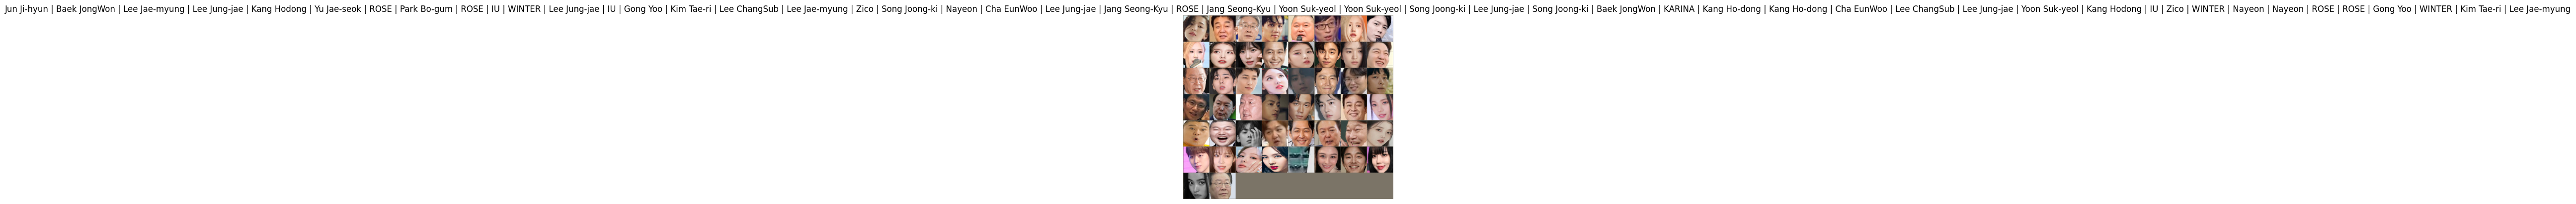

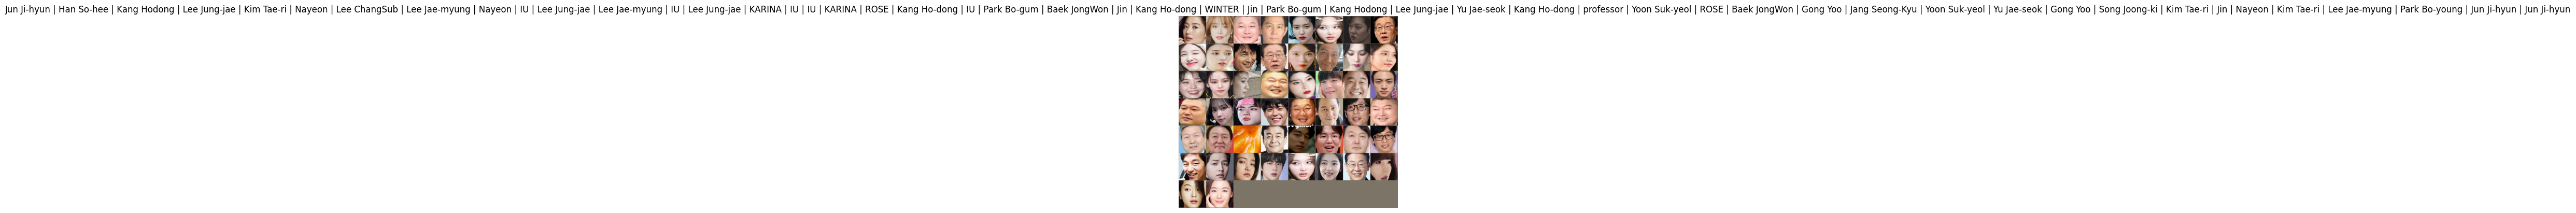

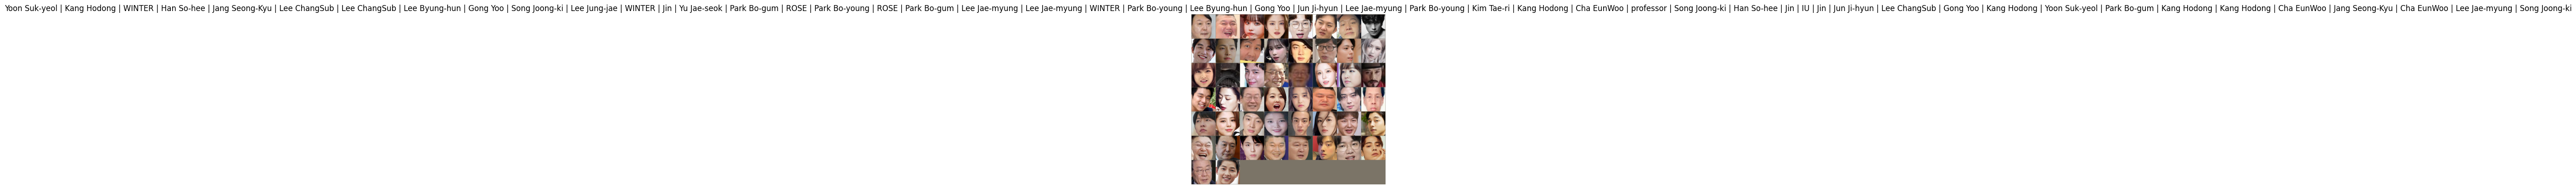

In [7]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Tensor 이미지를 시각화"""
    inp = inp.numpy().transpose((1, 2, 0))  # (C, H, W) → (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # 정규화 해제
    inp = np.clip(inp, 0, 1)  # 0~1로 값 제한
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # 축 제거
    plt.pause(0.001)  # 그래프 갱신을 위해 일시 정지

# 시각화할 이미지 개수 설정
num_show_img = 50  # 적당히 보여줄 이미지 개수

# Train 데이터 확인
inputs, classes = next(iter(dataloaders['train']))  # 첫 번째 배치 가져오기
num_show_img = min(len(classes), num_show_img)  # 배치 크기와 비교해 제한
out = torchvision.utils.make_grid(inputs[:num_show_img])  # 설정한 개수만 그리드로 결합
imshow(out, title=" | ".join([class_names[x] for x in classes[:num_show_img]]))

# Validation 데이터 확인
inputs, classes = next(iter(dataloaders['valid']))  # 첫 번째 배치 가져오기
num_show_img = min(len(classes), num_show_img)
out = torchvision.utils.make_grid(inputs[:num_show_img])
imshow(out, title=" | ".join([class_names[x] for x in classes[:num_show_img]]))

# Test 데이터 확인
inputs, classes = next(iter(dataloaders['test']))  # 첫 번째 배치 가져오기
num_show_img = min(len(classes), num_show_img)
out = torchvision.utils.make_grid(inputs[:num_show_img])
imshow(out, title=" | ".join([class_names[x] for x in classes[:num_show_img]]))


# 트레이닝

In [8]:
import time
import copy
import torch

def train_model(model, criterion, optimizer, scheduler, dataloaders, device, num_epochs=25):
    since = time.time()

    # 초기 설정
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_idx = 0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 학습 및 검증 단계
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 학습 모드
            else:
                model.eval()   # 평가 모드

            running_loss, running_corrects, num_cnt = 0.0, 0, 0

            # 데이터 로드
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 옵티마이저 초기화
                optimizer.zero_grad()

                # 순전파
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 역전파 및 옵티마이저 업데이트 (학습 단계에서만)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계 업데이트
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)

            # 스케줄러 업데이트 (학습 단계 끝에서만 호출)
            if phase == 'train':
                scheduler.step()

            # 손실 및 정확도 계산
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc = float((running_corrects.double() / num_cnt).cpu() * 100)

            # 결과 저장
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)

            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))

            # 최적의 모델 저장
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('==> Best model saved - Epoch: {} / Acc: {:.1f}'.format(best_idx, best_acc))

    # 학습 완료 시간 계산
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Acc: Epoch {} - {:.1f}'.format(best_idx, best_acc))

    # 최적의 모델 로드 및 저장
    model.load_state_dict(best_model_wts)
    model_save_path = 'best_model.pt'
    torch.save(model.state_dict(), model_save_path)
    print(f'Model saved at {model_save_path}')

    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc


In [12]:
# device 설정을 CPU로 고정
device = torch.device("cpu")  # GPU 대신 CPU를 사용
print(f"Using device: {device}")

# 모델을 CPU로 이동
model = model.to(device)

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 옵티마이저 설정
optimizer_ft = optim.SGD(
    model.parameters(),
    lr=0.05,
    momentum=0.9,
    weight_decay=1e-4
)

# 학습률 스케줄러 설정
lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

# 학습 시작
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer_ft,
    scheduler=exp_lr_scheduler,
    dataloaders=dataloaders,  # 데이터 로더 전달
    device=device,  # CPU 사용
    num_epochs=20
)


Using device: cpu
Epoch 0/19
----------
train Loss: 0.02 Acc: 99.6
valid Loss: 0.79 Acc: 82.9
==> Best model saved - Epoch: 0 / Acc: 82.9
Epoch 1/19
----------
train Loss: 0.01 Acc: 99.8
valid Loss: 0.91 Acc: 81.2
Epoch 2/19
----------
train Loss: 0.01 Acc: 99.6
valid Loss: 0.91 Acc: 76.5
Epoch 3/19
----------
train Loss: 0.01 Acc: 99.7
valid Loss: 0.82 Acc: 80.0
Epoch 4/19
----------
train Loss: 0.01 Acc: 99.7
valid Loss: 0.93 Acc: 78.2
Epoch 5/19
----------
train Loss: 0.01 Acc: 99.8
valid Loss: 0.82 Acc: 81.8
Epoch 6/19
----------
train Loss: 0.01 Acc: 99.8
valid Loss: 0.79 Acc: 81.8
Epoch 7/19
----------
train Loss: 0.01 Acc: 99.9
valid Loss: 0.79 Acc: 81.2
Epoch 8/19
----------
train Loss: 0.01 Acc: 99.7
valid Loss: 0.82 Acc: 82.9
Epoch 9/19
----------
train Loss: 0.01 Acc: 99.9
valid Loss: 0.82 Acc: 82.4
Epoch 10/19
----------
train Loss: 0.01 Acc: 99.8
valid Loss: 0.77 Acc: 83.5
==> Best model saved - Epoch: 10 / Acc: 83.5
Epoch 11/19
----------
train Loss: 0.01 Acc: 99.8
valid 

# 결과 출력

Using device: cpu
Current working directory: c:\GitHub\Stupid_Moon\deu_university\Digital Image Fundamentals\Teamproject
Number of classes: 26
Class names: ['Baek JongWon', 'Cha EunWoo', 'Gong Yoo', 'Han So-hee', 'IU', 'Jang Seong-Kyu', 'Jin', 'Jun Ji-hyun', 'Kang Ho-dong', 'Kang Hodong', 'KARINA', 'Kim Tae-ri', 'Lee Byung-hun', 'Lee ChangSub', 'Lee Jae-myung', 'Lee Jung-jae', 'Nayeon', 'Park Bo-gum', 'Park Bo-young', 'professor', 'ROSE', 'Song Joong-ki', 'WINTER', 'Yoon Suk-yeol', 'Yu Jae-seok', 'Zico']
Model loaded from: c:\GitHub\Stupid_Moon\deu_university\Digital Image Fundamentals\Teamproject\best_model.pt
Model is ready for testing!
Found 5 images for testing.


C:\Users\shado\AppData\Local\Temp\ipykernel_19504\3794100040.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_locat

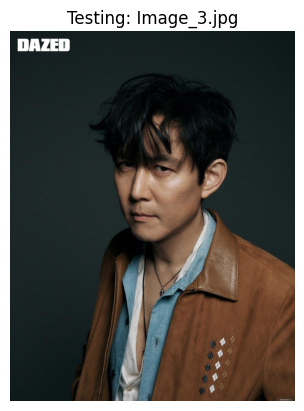

Results for Image_3.jpg:
  Class: Lee Byung-hun | Similarity: 47.01%
  Class: Gong Yoo | Similarity: 19.25%
  Class: professor | Similarity: 12.77%
-----


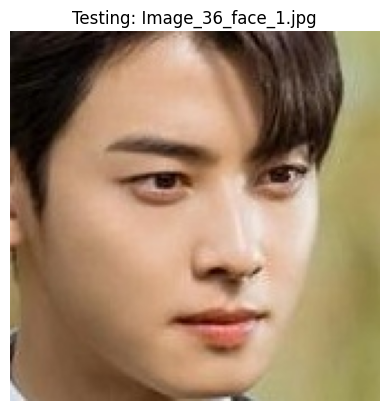

Results for Image_36_face_1.jpg:
  Class: Cha EunWoo | Similarity: 100.00%
  Class: Lee ChangSub | Similarity: 0.00%
  Class: Jin | Similarity: 0.00%
-----


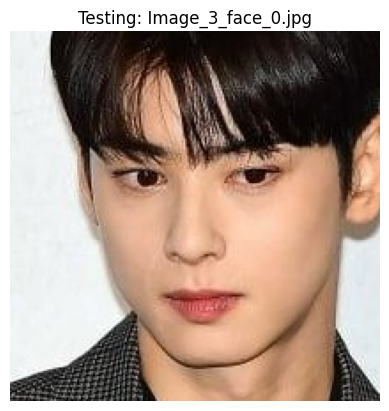

Results for Image_3_face_0.jpg:
  Class: Cha EunWoo | Similarity: 99.89%
  Class: Jin | Similarity: 0.05%
  Class: Yu Jae-seok | Similarity: 0.04%
-----


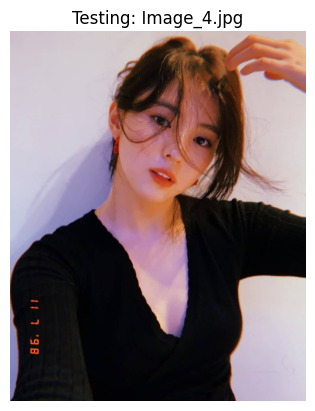

Results for Image_4.jpg:
  Class: Jin | Similarity: 26.23%
  Class: Lee Jung-jae | Similarity: 18.53%
  Class: Gong Yoo | Similarity: 13.10%
-----


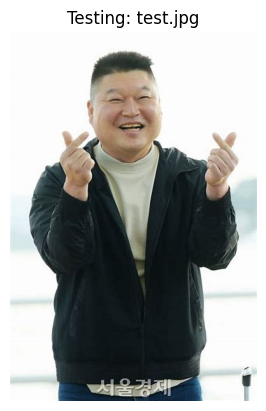

Results for test.jpg:
  Class: Jin | Similarity: 29.78%
  Class: Gong Yoo | Similarity: 15.38%
  Class: Lee Byung-hun | Similarity: 13.94%
-----


In [16]:
import os
import glob
import torch
import cv2
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet

# 장치 설정 (GPU 또는 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 현재 작업 디렉토리 확인
print(f"Current working directory: {os.getcwd()}")

# 학습 데이터셋 경로
data_set_dir = r"C:\GitHub\Stupid_Moon\deu_university\Digital Image Fundamentals\Teamproject\data_set"

# 학습한 클래스 이름 및 클래스 수 자동 설정
class_names = [d for d in os.listdir(data_set_dir) if os.path.isdir(os.path.join(data_set_dir, d))]
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# 모델 경로 설정
model_load_path = os.path.join(os.getcwd(), 'best_model.pt')
if not os.path.exists(model_load_path):
    raise FileNotFoundError(f"Model file not found at: {model_load_path}")
print(f"Model loaded from: {model_load_path}")

# 모델 로드
model_name = 'efficientnet-b0'
model = EfficientNet.from_name(model_name, num_classes=num_classes)
model.load_state_dict(torch.load(model_load_path, map_location=device))
model = model.to(device)
model.eval()
print("Model is ready for testing!")

# 테스트 이미지 경로 설정
test_image_dir = r"C:\GitHub\Stupid_Moon\deu_university\Digital Image Fundamentals\Teamproject\test_image"
image_list = glob.glob(os.path.join(test_image_dir, '*.jpg'))  # 테스트 폴더 내 모든 이미지 탐색

if not image_list:
    raise FileNotFoundError(f"No images found in directory: {test_image_dir}")
print(f"Found {len(image_list)} images for testing.")

# 이미지 전처리 정의
tfms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# 테스트 이미지 처리 및 결과 출력
for image_path in image_list:
    # 이미지 로드 및 시각화
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Testing: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()

    # 전처리
    img = tfms(Image.open(image_path)).unsqueeze(0).to(device)

    # 모델 예측
    with torch.no_grad():
        outputs = model(img)
        probabilities = torch.softmax(outputs, dim=1).squeeze(0)

    # 상위 k개 클래스 결과 출력
    print(f"Results for {os.path.basename(image_path)}:")
    topk = torch.topk(probabilities, k=min(3, num_classes))
    for idx, prob in zip(topk.indices.tolist(), topk.values.tolist()):
        print(f"  Class: {class_names[idx]} | Similarity: {prob * 100:.2f}%")
    print("-----")
